#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [117]:
!pip install -q workalendar 


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [155]:
from datetime import date
from workalendar.europe import Russia
from sklearn.preprocessing import FunctionTransformer

In [119]:
import numpy as np
import warnings 

from scipy import stats as st
import seaborn as sns
warnings.filterwarnings('ignore') # отключаем предупреждения

import pandas as pd
import matplotlib.pyplot as plt



from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,TimeSeriesSplit

from sklearn.metrics import mean_squared_error


from statsmodels.tsa.seasonal import seasonal_decompose

## Подготовка

In [120]:
try:
    data = pd.read_csv('taxi.csv')
except:
    data = pd.read_csv('/datasets/taxi.csv')
    

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [122]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [123]:
data['datetime']=pd.to_datetime(data['datetime'], format='%Y.%m.%d %H:%M:%S')

In [124]:
data = data.set_index('datetime')

In [125]:
data=data.sort_index()

In [126]:
data=data.resample('1H').sum()

In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [128]:
print(data.index.is_monotonic)

True


In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

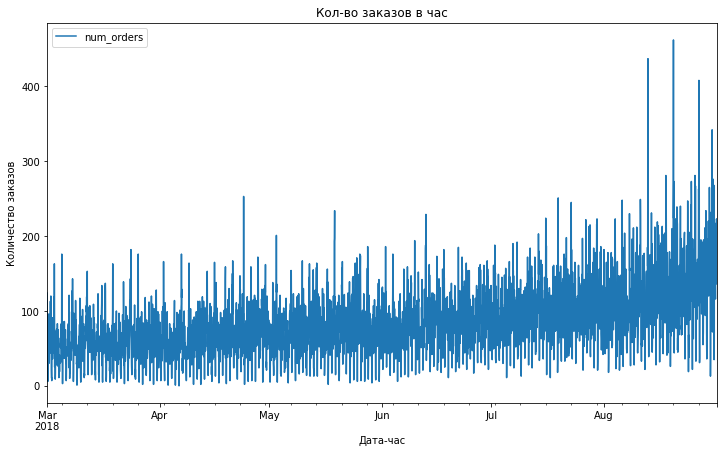

In [130]:

data.plot(title='Кол-во заказов в час',figsize=(12,7),xlabel='Дата-час',ylabel='Количество заказов');

In [151]:
data['rolling_mean'] = data['num_orders'].rolling(24*7).mean()

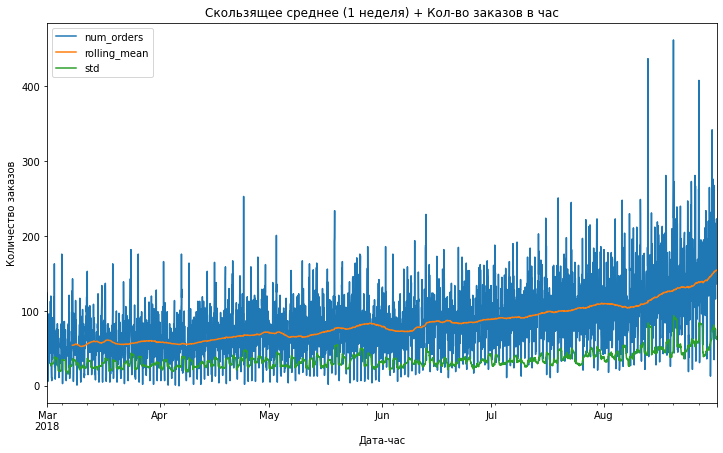

In [152]:
data.plot(title="Скользящее среднее (1 неделя) + Кол-во заказов в час",\
          figsize=(12,7),\
          xlabel='Дата-час',\
          ylabel='Количество заказов')
plt.show()

Как видно на графике скользящее среднее с окном равном 1 недели - на протяжении всего времени наблюдения растет. Далее посмотрим на уровни тренда, сезонности и остатка.

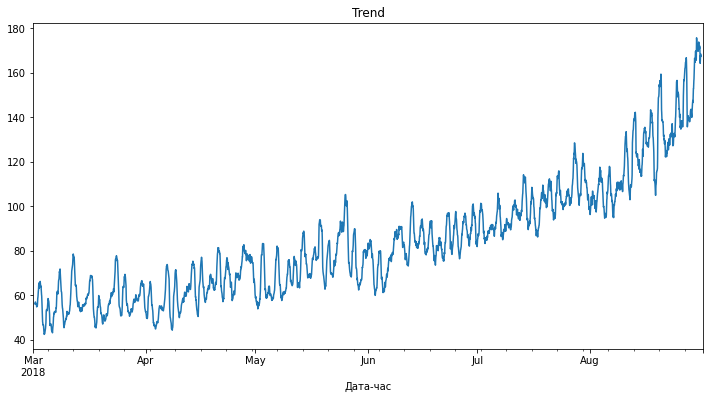

In [137]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(12, 6))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Дата-час')
plt.show()


На протяжении всего срока наблюдения мы отчетливо замечаем тренд роста кол-ва заказов.

Рассмотрим суточную сезонность

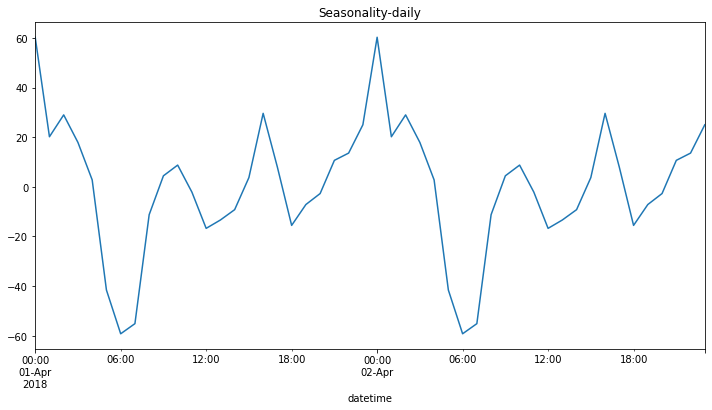

In [141]:
plt.figure(figsize=(12, 6))
decomposed.seasonal['2018-04-01':'2018-04-02'].plot(ax=plt.gca())
plt.title('Seasonality-daily')

plt.show()

В рамках суточных колебаний мы видим следующую закономерность:
- самое большое кол-во заказов приходится на полночь, а минимум на 6 утра.
- Локальные минимумы заказов в 12-00 и 18-00
- Локальные максимумы заказов в 11-00 и 16-00.

Рассмотрим сезонность в рамках недели

In [140]:
data_daily=data.resample('1D').sum()
decomposed_daily = seasonal_decompose(data_daily['num_orders'])


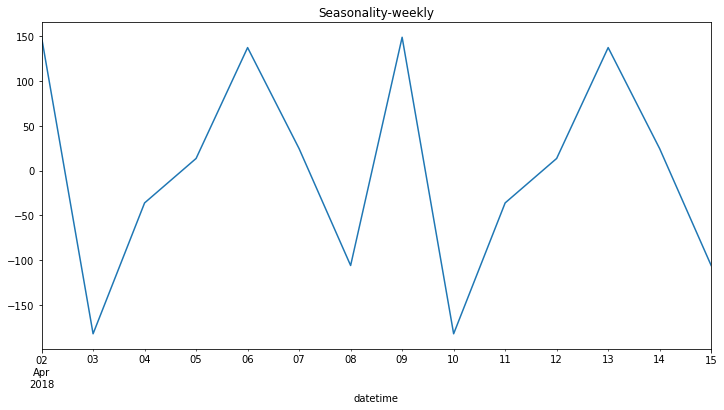

In [145]:
plt.figure(figsize=(12, 6))
decomposed_daily.seasonal['2018-04-02':'2018-04-15'].plot(ax=plt.gca())
plt.title('Seasonality-weekly')


plt.show()

В рамках недельной сезонности мы замечаем падение кол-ва заказов ко вторнику, после чего идет плавный рост заказов до пятницы, после чего опять происходит падение до воскресенья. Потом резкий скачок в понедельник, а затем резкое падение во вторник.

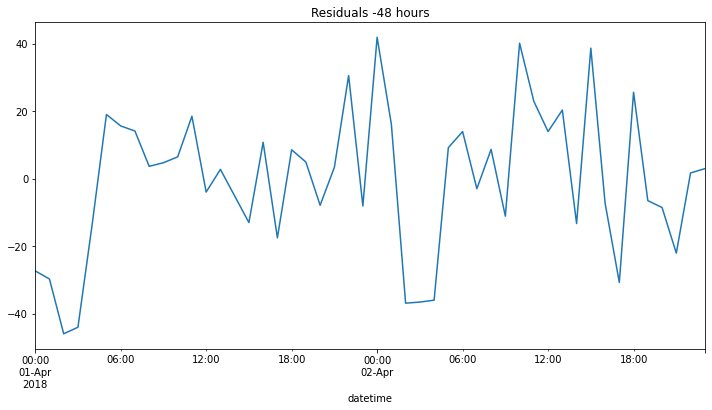

In [147]:
plt.figure(figsize=(12, 6))
decomposed.resid['2018-04-01':'2018-04-02'].plot(ax=plt.gca())
plt.title('Residuals -48 hours')
plt.show()

Необъясныемые ни трендом ни сезонностью "Шумы" так же имеют место быть в наших данных.

Проверим наши данные на продмет постоянности стандартного отклонения.

In [148]:
data['std'] = data['num_orders'].rolling(24).std()
data['rolling_mean']=data['num_orders'].rolling(24).mean()

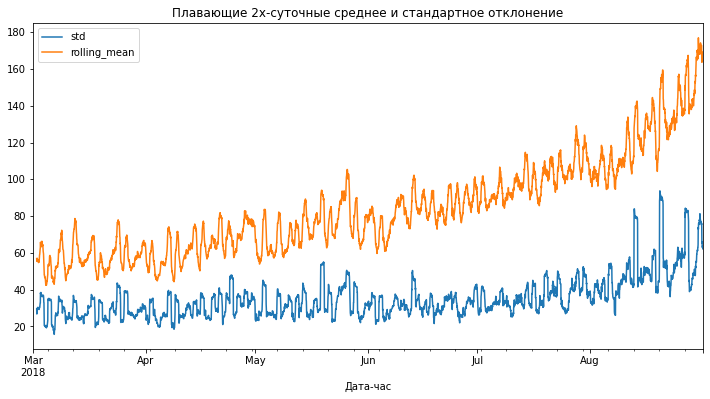

In [149]:
data[['std','rolling_mean']].plot(title = "Плавающие 2x-суточные среднее и стандартное отклонение",\
          xlabel='Дата-час',\
         figsize=(12,6));

Анализируя график мы видим, что "Скользящее среднее" что стандартное отклонение имют тенденци к росту, то есть временные ряды не стационарны. Однако, поскольку используемые инструменты в данном проекты не требуют чтобы данные были стационарны - их дальнейшее преобразование не обязательно.

In [153]:
data = data.drop(['std','rolling_mean'],axis=1)

### Вывод

На протяжении всего срока наблюдения мы отчетливо замечаем тренд роста кол-ва заказов, что может говорить о положительных показателях развития бизнеса. 

В рамках недельной сезонности мы замечаем падение кол-ва заказов ко вторнику, после чего идет плавный рост заказов до пятницы, после чего опять происходит падение до воскресенья. Потом резкий скачок в понедельник, а затем резкое падение во вторник. То есть происходит регулярные колебания, которые смогут помочь нам в дальнейшем построить более точный прогноз.
В Рамках суток мы так же наблдаем закономерности (пик в полночь, минимум в 6 утра + лоакальные повышения и снижения спроса в утром и в обед) 

***Выделим нецелевые признаки для данных***

In [175]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

При генерации признаков беру значение для "отстающего признака" за 6 часа до предсказываемого, так как кажется, что больше - уже слишком большой срок чтобы они влияли (дорожная ситуация уже точно поменяется)

а для понимания общего тренда я назначу окно для скользящего среднего в 8 часов.

In [176]:
make_features(data, 24, 168)


In [177]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))



In [178]:
data["dayw_sin"] = sin_transformer(7).fit_transform(data)["dayofweek"]
data["dayw_cos"] = cos_transformer(7).fit_transform(data)["dayofweek"]

In [179]:
data["hour_sin"] = sin_transformer(24).fit_transform(data)["hour"]
data["hour_cos"] = cos_transformer(24).fit_transform(data)["hour"]

In [180]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   lag_1         4415 non-null   float64
 2   lag_2         4414 non-null   float64
 3   lag_3         4413 non-null   float64
 4   lag_4         4412 non-null   float64
 5   lag_5         4411 non-null   float64
 6   lag_6         4410 non-null   float64
 7   lag_7         4409 non-null   float64
 8   lag_8         4408 non-null   float64
 9   lag_9         4407 non-null   float64
 10  lag_10        4406 non-null   float64
 11  lag_11        4405 non-null   float64
 12  lag_12        4404 non-null   float64
 13  lag_13        4403 non-null   float64
 14  lag_14        4402 non-null   float64
 15  lag_15        4401 non-null   float64
 16  lag_16        4400 non-null   float64
 17  lag_17        4399 non-null

***Добавление дополнительного признака - рабочий/выходной день***

Поскольку спрос на такси может отличаться в выходной/не выходной день я добавлю дополнительный параметр - is_working_day. Для этого из билиотеки workalendar выгружу данные для России за 2018 год и задам функцию с помощью которой построчно буду проверять является ли дата  выходным или рабочим днем.

In [181]:
def is_working_day(row):
    cal = Russia()
    cal.holidays(2018)
    
    return cal.is_working_day(date(int(2018), int(row['month']),int(row['day'])))

In [182]:
data['is_working'] = data.apply(is_working_day,axis=1)

In [183]:
data = data.drop(['hour','dayofweek','day','month'],axis=1)

***Разделим выборки***

In [184]:
train, test = train_test_split(data,shuffle=False,test_size=0.1)

In [185]:
train=train.dropna()

In [194]:
train.shape

(3806, 31)

In [195]:
test.shape

(442, 31)

In [188]:
train_target = train['num_orders']
train_features = train.drop(['num_orders'],axis=1)

test_target = test['num_orders']
test_features = test.drop(['num_orders'],axis=1)

Поскольку данных не много я не стала выделять валидационную выборку, а для сравнения кач-ва моделей планирую использовать TimeSeriesSplit. 

## Обучение

***LinearRegression***

In [189]:
model = LinearRegression()


In [196]:
lin_reg_rmse=-1*cross_val_score(model, train_features, train_target,\
                                cv=TimeSeriesSplit(n_splits=4)\
                                ,scoring='neg_root_mean_squared_error').mean()

In [199]:
lin_reg_params="-"

In [200]:
lin_reg_rmse

26.63802341879555

#### примечание 
Поскольку в линейной регрессии подбирать гиперпараметры не имеет смысла - я оценила качество модели с помощью кросс валидации. Вместо встроенного метода разбивки на подвыборки я использую специальный сплиттер для временных рядов - скользящая валидационная выборка смещается, а в обущающую выборку не попадают данные "из будущего"  в каждой итерации как бы это происхоило при стандартной кросс-валидации. Далее в GridSearch я буду использовать его же. и то же кол-во разбиений чтобы можно было сравнивать средний RMSE в каждой проверке. 

Линейная Регрессия показала удовлетворительный RMSE. В следующих Моделях попробуем улучшить результат.

***Random Forest Regressor***

In [201]:
model = RandomForestRegressor(n_jobs=-1,random_state=12345)

In [202]:
params={'n_estimators': range(70,400,50),
        'max_depth': range(3,25,5)
        
       }

In [203]:
grid = GridSearchCV(model, params,scoring = 'neg_root_mean_squared_error',\
                    cv=TimeSeriesSplit(n_splits=4))

In [204]:
grid.fit(train_features,train_target)
best_p=grid.best_params_
print(best_p)

{'max_depth': 23, 'n_estimators': 320}


In [205]:
random_forest_rmse=grid.best_score_*-1
random_forest_params=grid.best_params_

In [206]:
random_forest_rmse

24.946498254269617

Случайный лес помог улучшить качество модели, но не значительно. Ищем дальше. попробуем градиентные бустинги

***Catboost Regressor***

In [207]:
cat_f=['is_working']

In [208]:
model = CatBoostRegressor()

In [209]:
params= {'learning_rate': [0.03, 0.1],
        'depth': range(3,15,2)
        }

In [210]:
grid = GridSearchCV(model, params,scoring = 'neg_root_mean_squared_error',\
                    cv=TimeSeriesSplit(n_splits=4).split(train_features),\
                    n_jobs=-1)

In [211]:
grid.fit(train_features,train_target,cat_features=cat_f,verbose=100)

best_p=grid.best_params_
print(best_p)

0:	learn: 28.8492725	total: 56.5ms	remaining: 56.4s
100:	learn: 18.1823452	total: 240ms	remaining: 2.13s
200:	learn: 16.6628985	total: 438ms	remaining: 1.74s
300:	learn: 15.6239218	total: 628ms	remaining: 1.46s
400:	learn: 14.6099590	total: 821ms	remaining: 1.23s
500:	learn: 13.7962759	total: 1.02s	remaining: 1.01s
600:	learn: 13.1014568	total: 1.22s	remaining: 812ms
700:	learn: 12.4695927	total: 1.44s	remaining: 615ms
800:	learn: 11.8790995	total: 1.64s	remaining: 408ms
900:	learn: 11.3159204	total: 1.83s	remaining: 201ms
999:	learn: 10.8230688	total: 2.06s	remaining: 0us
0:	learn: 27.9835264	total: 2.05ms	remaining: 2.05s
100:	learn: 15.2761957	total: 197ms	remaining: 1.75s
200:	learn: 12.7816886	total: 421ms	remaining: 1.67s
300:	learn: 10.8133417	total: 615ms	remaining: 1.43s
400:	learn: 9.2924252	total: 820ms	remaining: 1.22s
500:	learn: 8.1315607	total: 1.01s	remaining: 1.01s
600:	learn: 7.2121674	total: 1.24s	remaining: 822ms
700:	learn: 6.3612261	total: 1.47s	remaining: 627ms
8

0:	learn: 32.6823496	total: 58.6ms	remaining: 58.6s
100:	learn: 21.1320577	total: 339ms	remaining: 3.02s
200:	learn: 19.5773296	total: 608ms	remaining: 2.42s
300:	learn: 18.6824754	total: 879ms	remaining: 2.04s
400:	learn: 18.0113995	total: 1.13s	remaining: 1.69s
500:	learn: 17.4414475	total: 1.45s	remaining: 1.45s
600:	learn: 16.9072299	total: 1.72s	remaining: 1.14s
700:	learn: 16.4333087	total: 1.99s	remaining: 850ms
800:	learn: 16.0012855	total: 2.29s	remaining: 570ms
900:	learn: 15.6586529	total: 2.59s	remaining: 284ms
999:	learn: 15.3149970	total: 2.88s	remaining: 0us
0:	learn: 31.7866122	total: 2.54ms	remaining: 2.54s
100:	learn: 18.5176215	total: 274ms	remaining: 2.44s
200:	learn: 16.6565113	total: 557ms	remaining: 2.21s
300:	learn: 15.3137881	total: 849ms	remaining: 1.97s
400:	learn: 14.2980628	total: 1.13s	remaining: 1.68s
500:	learn: 13.4835057	total: 1.43s	remaining: 1.42s
600:	learn: 12.7811224	total: 1.71s	remaining: 1.14s
700:	learn: 12.1654326	total: 1.99s	remaining: 850

500:	learn: 11.0392361	total: 3.99s	remaining: 3.98s
600:	learn: 9.9832300	total: 4.75s	remaining: 3.16s
700:	learn: 9.0599621	total: 5.52s	remaining: 2.36s
800:	learn: 8.2769309	total: 6.28s	remaining: 1.56s
900:	learn: 7.5745870	total: 7.06s	remaining: 776ms
999:	learn: 6.9805080	total: 7.88s	remaining: 0us
0:	learn: 33.8119145	total: 30.8ms	remaining: 30.8s
100:	learn: 19.8362237	total: 2.95s	remaining: 26.3s
200:	learn: 17.7095719	total: 5.03s	remaining: 20s
300:	learn: 16.3375065	total: 7.49s	remaining: 17.4s
400:	learn: 15.1330441	total: 9.56s	remaining: 14.3s
500:	learn: 13.9174161	total: 11.6s	remaining: 11.6s
600:	learn: 12.9273774	total: 13.7s	remaining: 9.09s
700:	learn: 12.0946031	total: 15.6s	remaining: 6.66s
800:	learn: 11.3702990	total: 18s	remaining: 4.47s
900:	learn: 10.6957047	total: 20s	remaining: 2.2s
999:	learn: 10.1024248	total: 21.8s	remaining: 0us
0:	learn: 32.6571957	total: 26.4ms	remaining: 26.3s
100:	learn: 15.7541649	total: 1.98s	remaining: 17.6s
200:	learn:

In [212]:
catboost_rmse=grid.best_score_*-1
catboost_params=grid.best_params_

In [213]:
catboost_rmse

24.81786345704378

***LightGBM***

In [214]:
model = lgb.LGBMRegressor(n_jobs=-1)

In [215]:
params = {
    "max_depth":range(-1,16,3),
    
    "n_estimators":range(70,400,50),
'learning_rate':[0.1,0.3,0.8]}

In [216]:
grid = GridSearchCV(model ,params,scoring = 'neg_root_mean_squared_error',\
                    cv=TimeSeriesSplit(n_splits=4).split(train_features))

In [217]:
grid.fit(train_features,train_target,verbose=100)


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f89c15910b0>,
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.3, 0.8],
                         'max_depth': range(-1, 16, 3),
                         'n_estimators': range(70, 400, 50)},
             scoring='neg_root_mean_squared_error')

In [218]:
light_gbm_rmse=grid.best_score_*-1
light_gbm_params=grid.best_params_

In [219]:
light_gbm_rmse

24.963650924230258

***XGBoost***

In [220]:
model = xgb.XGBRegressor(n_jobs=-1)

In [221]:
params = {
    "max_depth":range(1,16,3),
    
    "n_estimators":range(70,400,50)}

In [222]:
grid = GridSearchCV(model ,params,scoring = 'neg_root_mean_squared_error',\
                    cv=TimeSeriesSplit(n_splits=4).split(train_features))

In [223]:
grid.fit(train_features,train_target)

0:	learn: 29.7810087	total: 949ms	remaining: 15m 47s
100:	learn: 3.7831299	total: 1m 30s	remaining: 13m 28s
200:	learn: 1.0478524	total: 2m 59s	remaining: 11m 53s
300:	learn: 0.3162628	total: 4m 26s	remaining: 10m 18s
400:	learn: 0.0896263	total: 6m 6s	remaining: 9m 8s
500:	learn: 0.0283955	total: 7m 47s	remaining: 7m 45s
600:	learn: 0.0090268	total: 9m 19s	remaining: 6m 11s
700:	learn: 0.0029523	total: 10m 35s	remaining: 4m 31s
800:	learn: 0.0009095	total: 11m 51s	remaining: 2m 56s
900:	learn: 0.0003004	total: 13m 1s	remaining: 1m 25s
999:	learn: 0.0000998	total: 14m 5s	remaining: 0us


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f89c14fec10>,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=N...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'max_depth': range(1, 16, 3),
                         'n_estimators': range(70, 400, 50)},
             scoring='neg_root_mean_squared_error')

In [224]:
xg_boost_rmse=grid.best_score_*-1
xg_boost_params=grid.best_params_

In [225]:
xg_boost_rmse

26.220323963481857

## Анализ моделей

In [234]:
models=['Linear Regression','Random Forest Regressor','CatBoost Regressor','LightGBM Regressor','XGBoost Regressor']
models_rmse=[lin_reg_rmse,random_forest_rmse,catboost_rmse,light_gbm_rmse,xg_boost_rmse]
models_params=[lin_reg_params,random_forest_params,catboost_params,light_gbm_params,xg_boost_params]

In [235]:
models_comparison=pd.DataFrame(list(zip(models_rmse,models_params)),columns=['RMSE','Model_params'],index=models)

In [236]:
models_comparison = models_comparison.sort_values(by='RMSE')

In [241]:
models_comparison

,RMSE,Model_params
CatBoost Regressor,24.817863,"{'depth': 7, 'learning_rate': 0.03}"
Random Forest Regressor,24.946498,"{'max_depth': 23, 'n_estimators': 320}"
LightGBM Regressor,24.963651,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti..."
XGBoost Regressor,26.220324,"{'max_depth': 4, 'n_estimators': 70}"
Linear Regression,26.638023,-


Модель с наименьшим RMSE -СatBoostRegressor. Однако стоит отметить, что все модели показывают близкий к лидеру результат.

## Тестирование

In [238]:
print(models_comparison.iloc[0])

RMSE                                      24.817863
Model_params    {'depth': 7, 'learning_rate': 0.03}
Name: CatBoost Regressor, dtype: object


In [242]:
model = CatBoostRegressor(depth= 7, learning_rate=0.03)

In [243]:
model.fit(train_features,train_target,cat_features=cat_f,verbose=100)
#model.fit(train_features.iloc[-(len(test)):],train_target.iloc[-(len(test)):],cat_features=cat_f,verbose=100)
#cat_features=cat_f,
#,verbose=0

0:	learn: 38.1024745	total: 14.4ms	remaining: 14.3s
100:	learn: 21.9380178	total: 798ms	remaining: 7.1s
200:	learn: 20.1705257	total: 1.82s	remaining: 7.23s
300:	learn: 18.6301092	total: 2.51s	remaining: 5.82s
400:	learn: 17.3623433	total: 3.19s	remaining: 4.76s
500:	learn: 16.1246150	total: 3.86s	remaining: 3.85s
600:	learn: 15.0147449	total: 4.73s	remaining: 3.14s
700:	learn: 14.1238270	total: 5.45s	remaining: 2.33s
800:	learn: 13.3378185	total: 6.14s	remaining: 1.53s
900:	learn: 12.6694486	total: 6.83s	remaining: 750ms
999:	learn: 12.0591788	total: 7.5s	remaining: 0us


In [244]:
predict=model.predict(test_features)

In [245]:
mean_squared_error(test_target,predict,squared=False)

40.4712215255382

In [248]:
result=pd.DataFrame(list(zip(predict,test_target)),\
                    columns=['Prediction','test'],\
                    index=test_target.index)

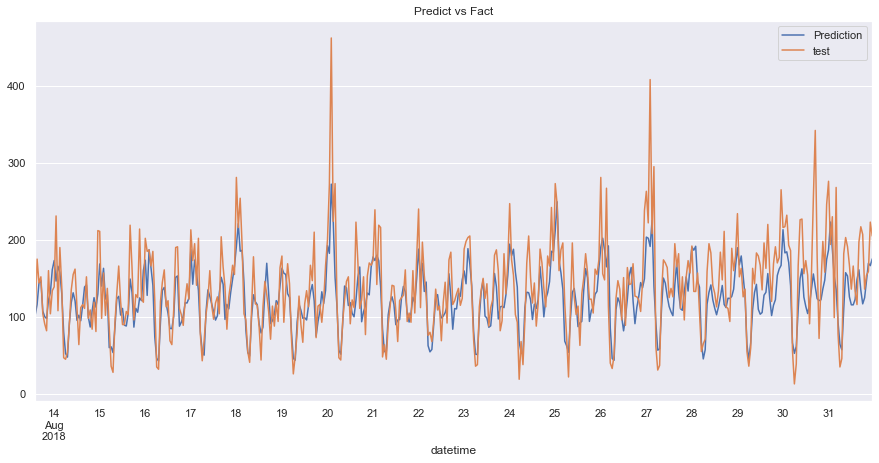

In [260]:
result.plot(title='Predict vs Fact',figsize=(15,7));

Качество на тестовой выборке ухудшилось, но все еще осталось в допустимых рамках . 

## Вывод

В рамках данного проекта передо мной стояла задача подбора оптимальной модели рпедсказания спроса на такси в рамках следующего часа. 

Для этого я осуществила ресэмплинг данных на 1час + добавила допольнительные параметры: год, месяц, день месяца, час, день недели, рабочий ли день, данные за предыдущие несколько часов и средний спрос за послдение 6 часов.

Мноб были подобраны 5 моделей - Линейная,Случайный лес, и 3и вида бустинга. Модель- победитель - CatboostREgressor RMSE при кроссвалидации на обучающей показал 24.8, на тесте - 40.47.